# Plotting
#### Use Similar Artist Data to [create network](#Network-Background) using NetworkX, then plot with:
## [matplotlib](#matplotlib-examples)
## [Plotly](#Plotly-examples)
*Plotly used within Dash application*
## [Network Layout Comparison, mpl subplots](#Network-Layout-Comparison)

----
### 
### Import Packages, Load Data

In [1]:
import json
from pathlib import Path

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
with open('ex_sim_artists.json', 'r', encoding = 'utf-8') as file:
    similar_artists = json.loads(file.read())
with open('ex_artists_alias.json', 'r', encoding = 'utf-8') as file:
    artists_alias = json.loads(file.read())

---
### 
## Network Background
#### [NetworkX Layout Options](https://networkx.org/documentation/stable/reference/drawing.html)
 * `spring_layout` *default, can set k value to adjust distance between nodes, along with scale and center*
   * increase k to 25 from default 1.5 if neighbors added
 * `spiral_layout` *usually ok with neighbors, always good without. can adjust resolution for more spacing*
   * scale resolution by number of nodes if neighbors added, `len(G.nodes)/25`
 * `circular_layout` *same as shell, main node on right. prefer shell*
   * not included in Dash application
 * `shell_layout` *cocentric circles, good for both with enough room*
   * defaults used
 * `spectral_layout` *not good for maps*
   * not included in Dash application
 * `kamada_kawai_layout` *sometimes ok, can be good for neighbors*
   * positions explicitly set if neighbors added `pos = nx.kamada_kawai_layout(G, pos=nx.kamada_kawai_layout(G))`
 * `planar_layout` *no edge intersections, can be good with space and for neighbors*
   * defaults used, adding neighbors can result in error
 * `bipartitle_layout` *two straight lines*
   * not included in Dash application
 * `multipartite_layout` *layers of straight lines*
   * not included in Dash application
 * `random_layout` *nodes uniformly positioned at random around unit square*
   * defaults used
   
*[compare the various network layouts](#Network-Layout-Comparison) using matplotlib subplots*

#### Network Creation

In [63]:
len(G.nodes)

11

In [61]:
# Network Settings: Artist, add neighbors

artist = 'M83'
if artist not in similar_artists.keys():
    print('Artist not found')
    
add_neighbors = False

*Artist names with `$`'s, may cause errors with matplotlib*

`<artist_name>.replace('$$','\\$\\$')` may be a necessary addition to the code below:

In [62]:
# Establish Network
G = nx.MultiGraph()

for val in similar_artists[artist]:
    
    # Add edge from Artist to each Similar Artist
    weight = np.power(val['score'], 0.85) # scale match score
    G.add_edge(artist,val['name'], weight=weight)
    
    # Include information about Similar Artists in library
    # these also have associated data
    if val['library']:
        # Adjust similar artist name, if alias present
        if val['name'] in similar_artists.keys():
            addname = val['name']
        elif val['name'] in artists_alias.keys():
            addname = artists_alias[val['name']]
        
        # Skip adding similar artist information if data not found
        else:
            continue
            
        # add_neighbors: include all connections from Similar Artist in library
        if add_neighbors:
            G.add_edges_from([(addname, val2['name'], np.power(val2['score'], 0.85)) \
                          for val2 in similar_artists[addname]])
        
        # no neighbors: only include connections from Similar Artist if already present in Network
        else:
            for val2 in similar_artists[addname]:
                if val2['name'] in list(G.nodes):
                    G.add_edge(val['name'], val2['name'], np.power(val2['score'], 0.85))

---
### 
### matplotlib examples
 * NetworkX, `draw_networkx` function used
 * color scheme highlights Artist of interest, and shows wheter similar artists in library or not
 * custom marker shape (rectangle) gives box around artist names

#### artist = `M83`
Example plots and similar artist data below: 

In [58]:
print('\n'.join([f"{val['name']}: {round(val['score']/1e5,1)}" for val in similar_artists[artist]]))

The Naked and Famous: 10.0
Phoenix: 10.0
Röyksopp: 9.4
Washed Out: 9.3
Passion Pit: 9.1
Sigur Rós: 9.0
Hammock: 8.4
Tycho: 8.4
School of Seven Bells: 8.3
The Big Pink: 8.1


### Spring Layout with Neighbors

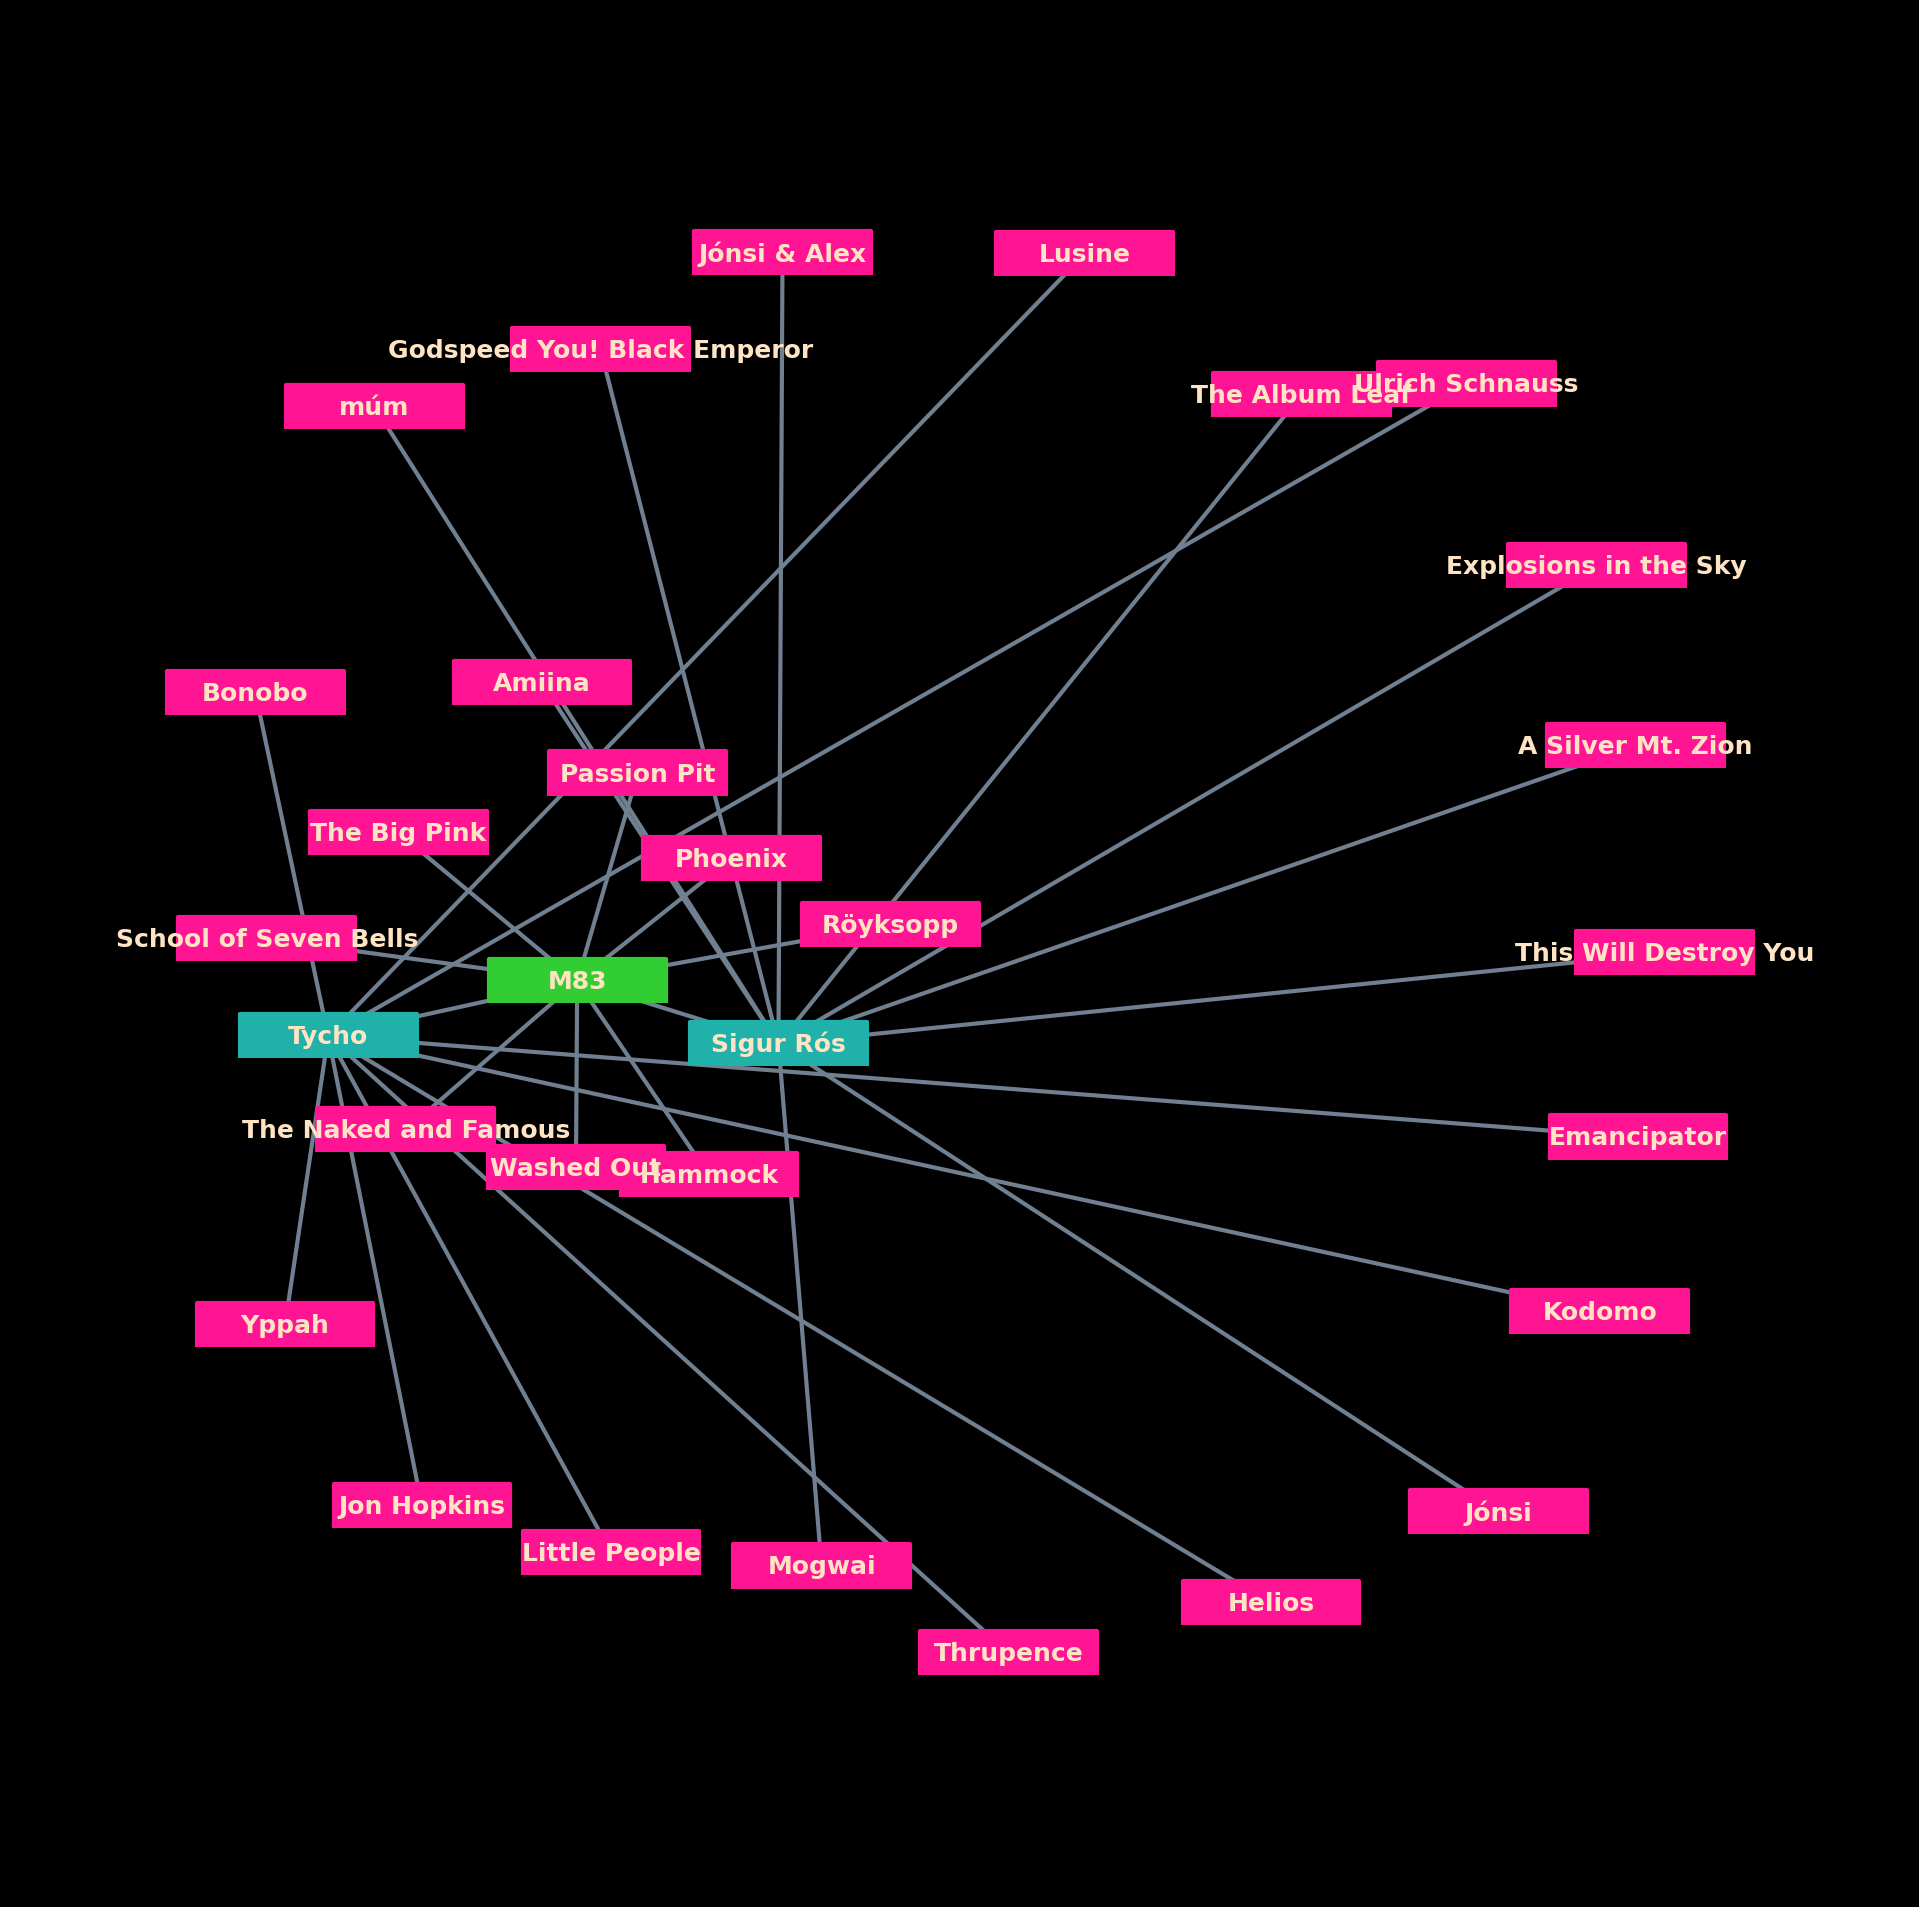

In [59]:
colors = []
for val in list(G.nodes):
    if val == artist:
        colors.append('limegreen')
    else:
        colors.append('lightseagreen' if val in similar_artists.keys() or val in artists_alias.keys() else 'deeppink')
        
fig = plt.figure(figsize=(8,8), facecolor='k', dpi=300)
nx.draw_networkx(G, nx.spring_layout(G, k = 25 if add_neighbors else 1.5), node_color=colors, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')
plt.show()

### Spring Layout without Neighbors

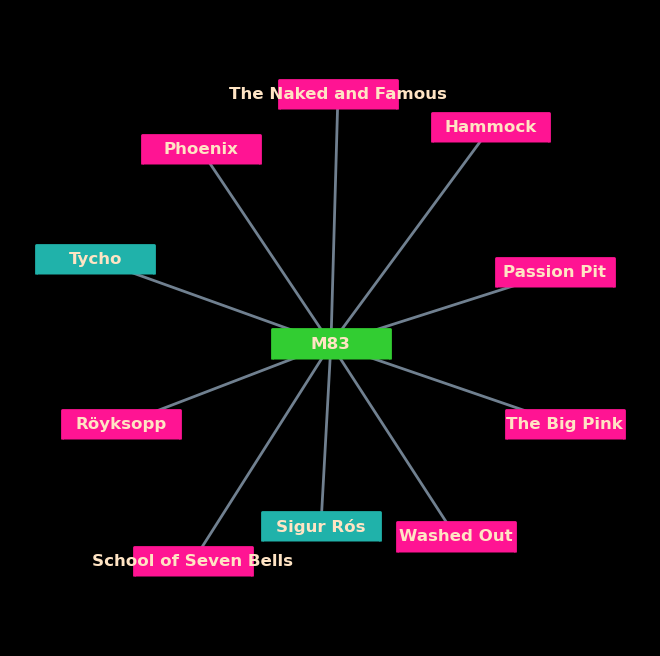

In [55]:
colors = []
for val in list(G.nodes):
    if val == artist:
        colors.append('limegreen')
    else:
        colors.append('lightseagreen' if val in similar_artists.keys() or val in artists_alias.keys() else 'deeppink')
        
fig = plt.figure(figsize=(4,4), facecolor='k', dpi=200)
nx.draw_networkx(G, nx.spring_layout(G, k = 25 if add_neighbors else 1.5), node_color=colors, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')
plt.show()

---
### 
### Plotly examples
 * Refer to [code above for network creation](#Network-Creation)
 * Network edges and positions are drawn using `go.Scatter` function
   * each edge plotted as line segment by using `mode='lines'` and including `None` in between each set of two points
   * each node plotted as Artist Name, with color scheme as described above
   * midpoint of each edge used to include match scores in hover information, scaled to 0-10
   * Dash Application Differences
     * more network information included in Dash application figure output
     * other information included as text or title within figure
     * figure sized by HTML/CSS
   
#### same data as used [above](#matplotlib-examples)
### Spring Layout with Neighbors

In [30]:
# positions of points and edges
pos = nx.spring_layout(G, k = 25 if add_neighbors else 1.5)

# disjointed lines for each edge
edge_x = []
edge_y = []

# label edges at midpoints
etext_x = []
etext_y = []
edge_text = []
etext_colors = []
inds = {val['name']:i for i,val in enumerate(similar_artists[artist])}

for edge in G.edges():
    # line segment
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
    # edge label
    etext_x.append((x0+x1)/2)
    etext_y.append((y0+y1)/2)    
    
    if edge[0] == artist:
        etext_colors.append('palegreen')
        edge_text.append(\
f'{edge[0]} ⟷ {edge[1]}: <b>{round(similar_artists[artist][inds[edge[1]]]["score"]/1e5,1)}</b>')
        
    else: # logic can be improved with better schema for similar_artists
        
        etext_colors.append('lemonchiffon') 
        if edge[0] in similar_artists.keys() and edge[1] in similar_artists.keys():
            if edge[1] in [val['name'] for val in similar_artists[edge[0]]]:
                key = 0
            else:
                key = 1
        elif edge[0] in similar_artists.keys():
            key = 0
        else:
            key = 1
        other = 1 if key == 0 else 0
        
        
        inds2 = {val['name']:i for i,val in enumerate(similar_artists[edge[key]])}
        edge_text.append(\
f'{edge[0]} ⟷ {edge[1]}: <b>{round(similar_artists[edge[key]][inds2[edge[other]]]["score"]/1e5,1)}</b>')

# edge lines
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='slategrey'),
    mode='lines')
# edge labels
eweights_trace = go.Scatter(x=etext_x,y= etext_y, text=edge_text, 
                            mode='markers', hoverinfo='text',
                            marker=dict(size=0,color=etext_colors))

# Nodes
colors = []
for val in list(G.nodes):
    if val == artist:
        colors.append('limegreen')
    else:
        colors.append('lightseagreen' if val in \
                      similar_artists.keys() else 'deeppink')
            
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y, text = [f'<b>{val}</b>' for val in list(G.nodes)],
    mode='markers+text',
    textfont = dict(size=16, color=colors),
    hoverinfo='text',
    marker=dict(
        color=colors,
        symbol='line-ew',
        size=1,  
        line_width=0))

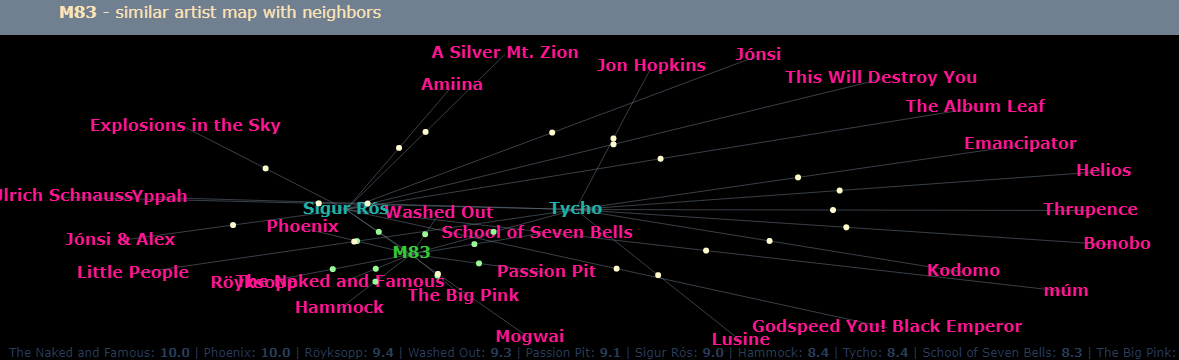

In [27]:
fig = go.Figure(data=[edge_trace, node_trace, eweights_trace],
             layout=go.Layout(
                title=f'<b>{artist.title()}</b> - similar artist map {"with neighbors" if add_neighbors else "without neighbors"}',
                titlefont_size=16,
                titlefont_color='moccasin',
                paper_bgcolor = 'slategrey',
                plot_bgcolor = 'black',
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=35),
                annotations=[ dict(
                    text=' | '.join([f"<a href='{val['link']}'>{val['name']}</a>: <b>{round(val['score']/1e5,1)}</b>" for val in similar_artists[artist]]),
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.005 )],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### Spring Layout without Neighbors

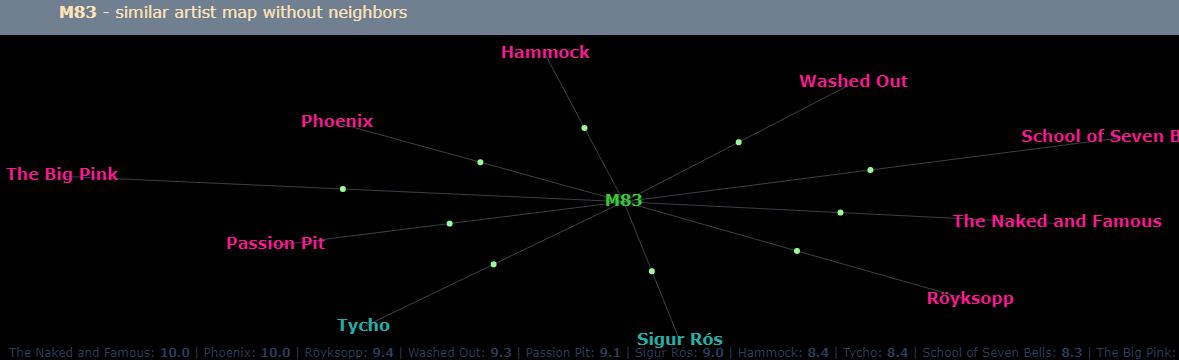

In [31]:
# Data prepared above

fig = go.Figure(data=[edge_trace, node_trace, eweights_trace],
             layout=go.Layout(
                title=f'<b>{artist.title()}</b> - similar artist map {"with neighbors" if add_neighbors else "without neighbors"}',
                titlefont_size=16,
                titlefont_color='moccasin',
                paper_bgcolor = 'slategrey',
                plot_bgcolor = 'black',
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=35),
                annotations=[ dict(
                    text=' | '.join([f"<a href='{val['link']}'>{val['name']}</a>: <b>{round(val['score']/1e5,1)}</b>" for val in similar_artists[artist]]),
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.005 )],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

---
###
### Network Layout Comparison
#### various layouts with and without neighbors
#### 
#### create networks:

In [64]:
# Neighbors - G
G = nx.MultiGraph()

for val in similar_artists[artist]:
    
    # Add edge from Artist to each Similar Artist
    weight = np.power(val['score'], 0.85) # scale match score
    G.add_edge(artist,val['name'], weight=weight)
    
    # Include information about Similar Artists in library
    # these also have associated data
    if val['library']:
        # Adjust similar artist name, if alias present
        if val['name'] in similar_artists.keys():
            addname = val['name']
        elif val['name'] in artists_alias.keys():
            addname = artists_alias[val['name']]
        
        # Skip adding similar artist information if data not found
        else:
            continue
            
        # add_neighbors: include all connections from Similar Artist in library
        G.add_edges_from([(addname, val2['name'], np.power(val2['score'], 0.85)) \
                          for val2 in similar_artists[addname]])

                    
# No Neighbors - H
H = nx.MultiGraph()

for val in similar_artists[artist]:
    
    # Add edge from Artist to each Similar Artist
    weight = np.power(val['score'], 0.85) # scale match score
    H.add_edge(artist,val['name'], weight=weight)
    
    # Include information about Similar Artists in library
    # these also have associated data
    if val['library']:
        # Adjust similar artist name, if alias present
        if val['name'] in similar_artists.keys():
            addname = val['name']
        elif val['name'] in artists_alias.keys():
            addname = artists_alias[val['name']]
        
        # Skip adding similar artist information if data not found
        else:
            continue

        # no neighbors: only include connections from Similar Artist if already present in Network
        for val2 in similar_artists[addname]:
            if val2['name'] in list(H.nodes):
                H.add_edge(val['name'], val2['name'], np.power(val2['score'], 0.85))

In [67]:
print(len(G.nodes), 'with neighbors\n', len(H.nodes), 'without neighbors')

31 with neighbors
 11 without neighbors


In [68]:
colors1 = []
for val in list(G.nodes):
    if val == artist:
        colors1.append('limegreen')
    else:
        colors1.append('lightseagreen' if val in \
                      similar_artists.keys() else 'deeppink')
        
colors2 = []
for val in list(H.nodes):
    if val == artist:
        colors2.append('limegreen')
    else:
        colors2.append('lightseagreen' if val in \
                      similar_artists.keys() else 'deeppink')

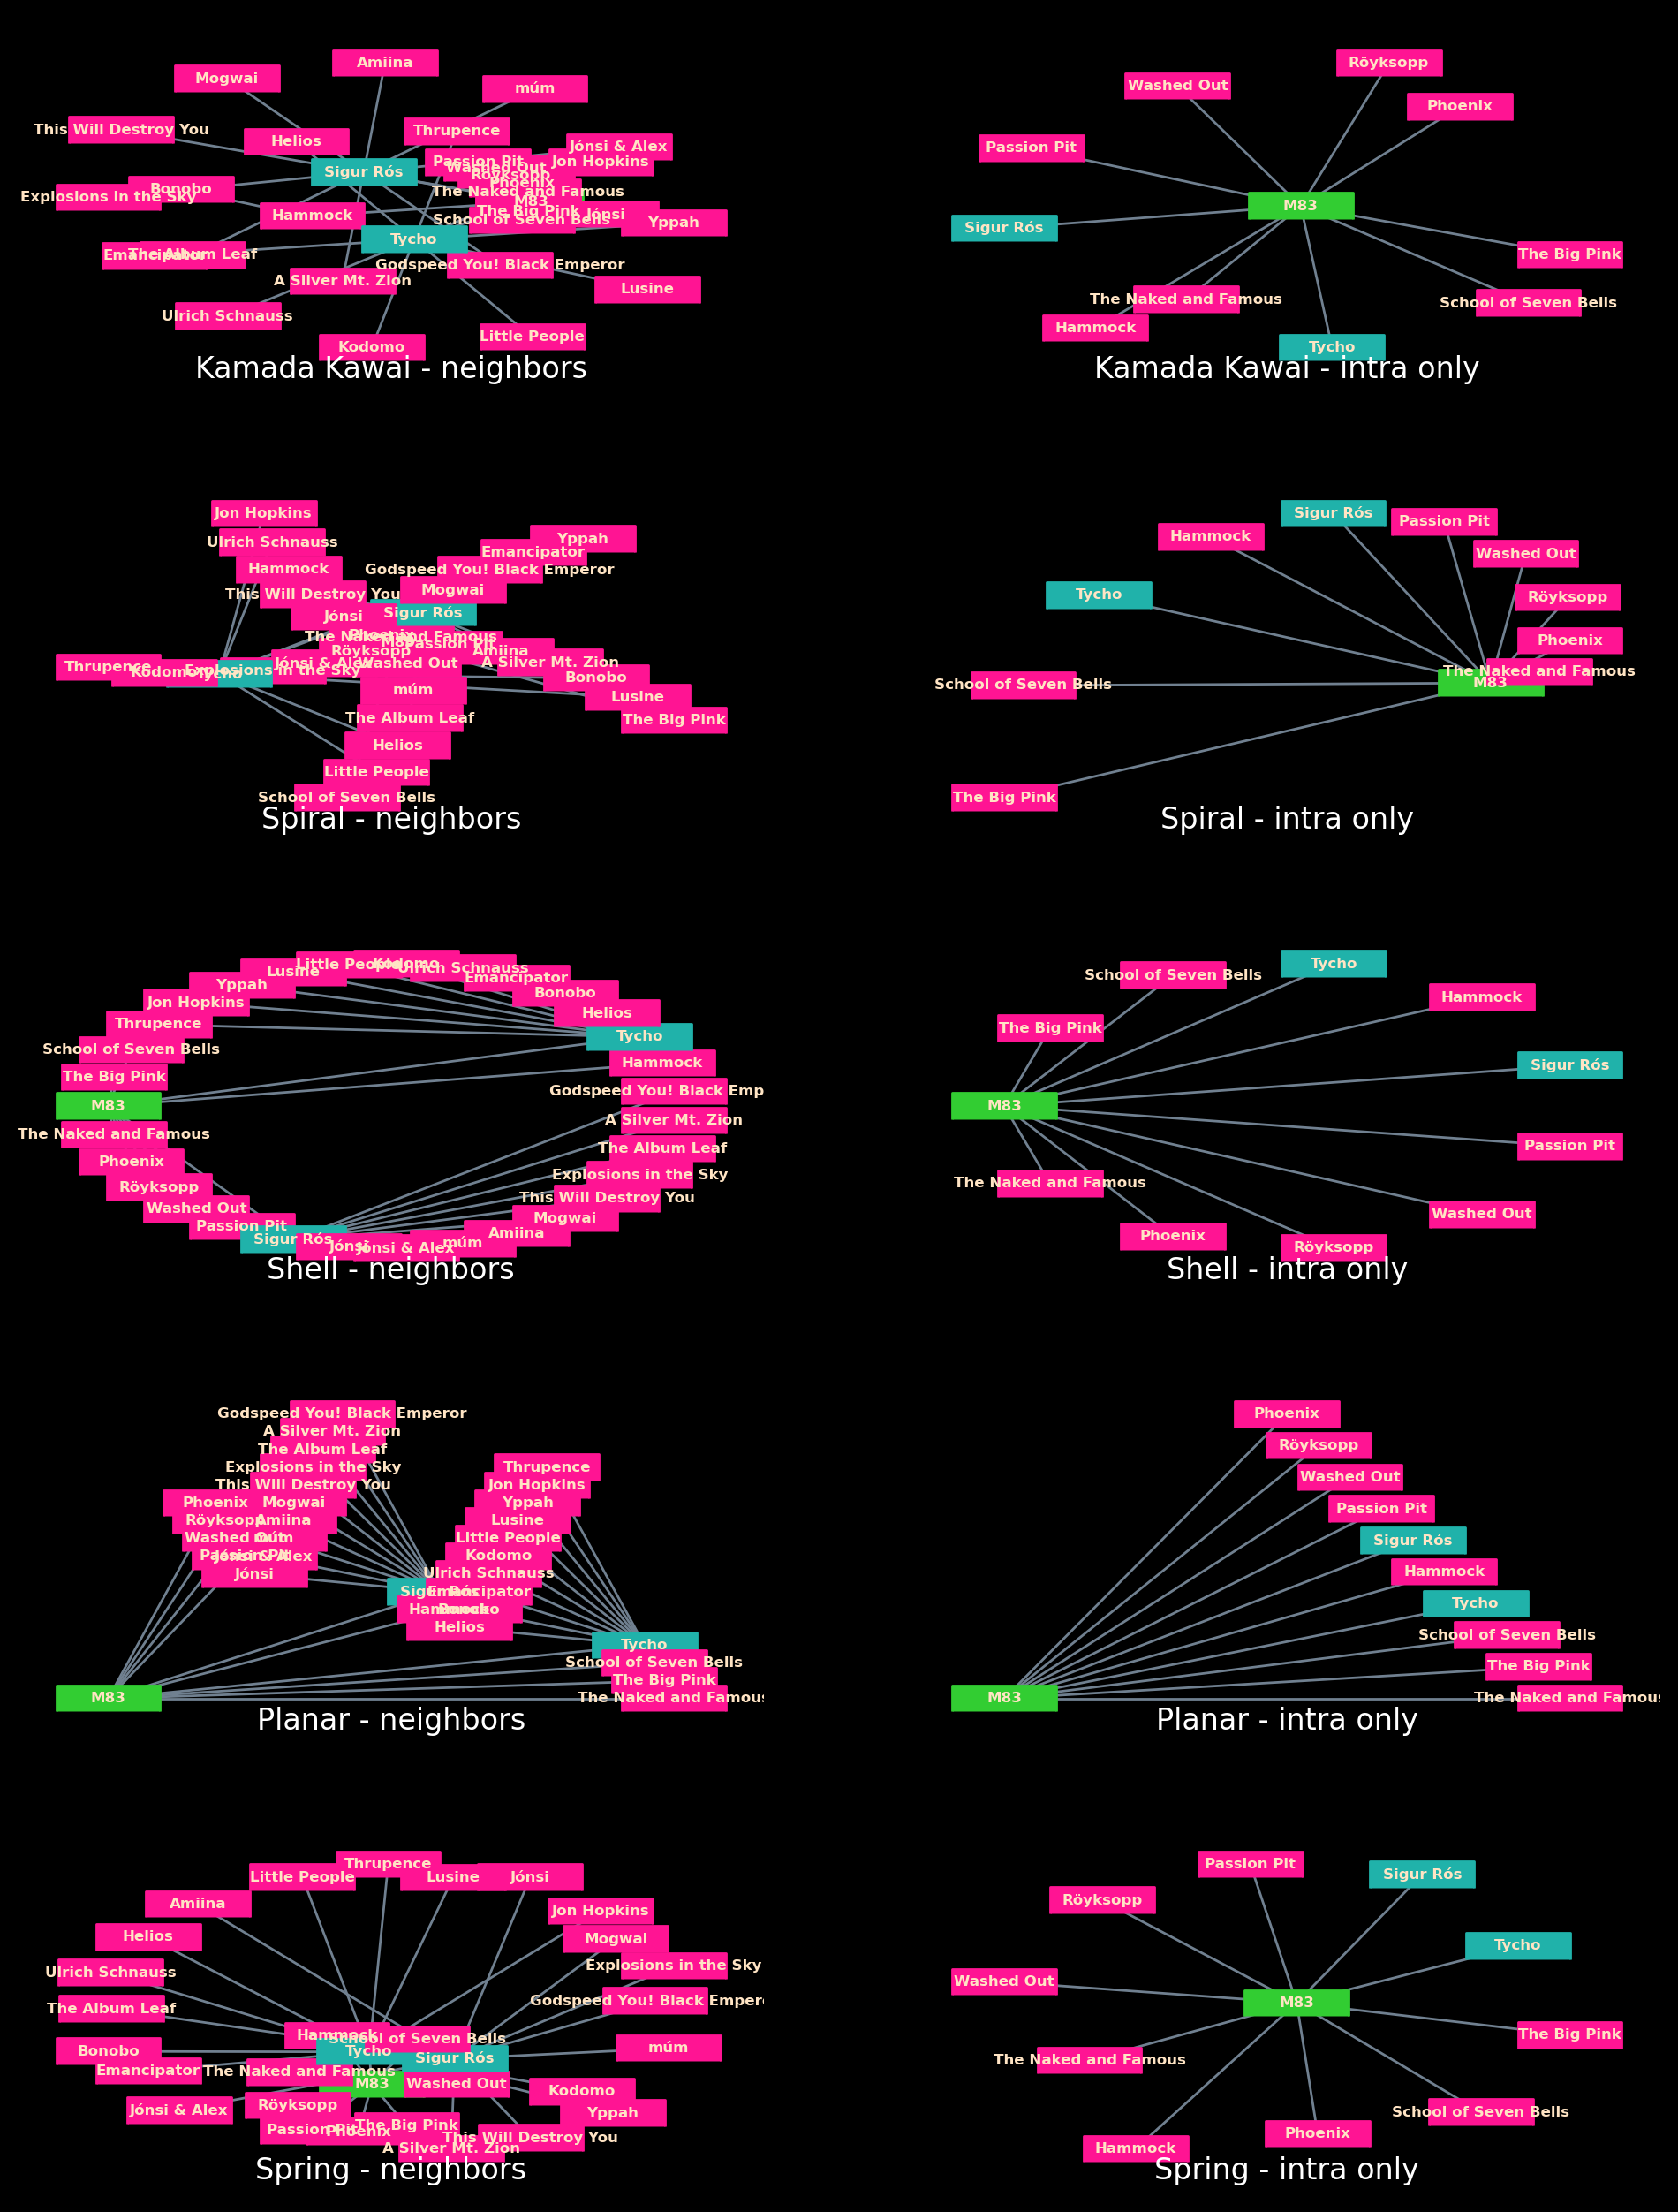

In [71]:
fig = plt.figure(figsize=(12,16), facecolor='k', dpi=200)

# kamada kawai
plt.subplot(5,2,1, facecolor='k')
plt.title('Kamada Kawai - neighbors',color='w', y=0)
nx.draw_networkx(G, nx.kamada_kawai_layout(G, pos=nx.kamada_kawai_layout(G)), node_color=colors1, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

plt.subplot(5,2,2)
plt.title('Kamada Kawai - intra only',color='w', y=0)
nx.draw_networkx(H, nx.kamada_kawai_layout(H), node_color=colors2, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

# spiral
plt.subplot(5,2,3, facecolor='k')
plt.title('Spiral - neighbors',color='w', y=0)
nx.draw_networkx(G, nx.spiral_layout(G, resolution=len(G.nodes)/25), node_color=colors1, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

plt.subplot(5,2,4)
plt.title('Spiral - intra only',color='w', y=0)
nx.draw_networkx(H, nx.spiral_layout(H), node_color=colors2, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

# shell
plt.subplot(5,2,5, facecolor='k')
plt.title('Shell - neighbors',color='w', y=0)
nx.draw_networkx(G, nx.shell_layout(G), node_color=colors1, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

plt.subplot(5,2,6)
plt.title('Shell - intra only',color='w', y=0)
nx.draw_networkx(H, nx.shell_layout(H), node_color=colors2, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

# planar
try:
    plt.subplot(5,2,7, facecolor='k')
    plt.title('Planar - neighbors',color='w', y=0)
    nx.draw_networkx(G, nx.planar_layout(G), node_color=colors1, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                     font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
    plt.margins(0.1)
    plt.axis('off')
except Exception as e:
    plt.subplot(5,2,7, facecolor='k')
    plt.title('Planar - neighbors',color='w', y=0)
    plt.text(0,1,str(e), color='r')
    pass

try:
    plt.subplot(5,2,8)
    plt.title('Planar - intra only',color='w', y=0)
    nx.draw_networkx(H, nx.planar_layout(H), node_color=colors2, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                     font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
    plt.margins(0.1)
    plt.axis('off')
except:
    pass

# spring
plt.subplot(5,2,9, facecolor='k')
plt.title('Spring - neighbors',color='w', y=0)
nx.draw_networkx(G, nx.spring_layout(G, k=25), node_color=colors1, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

plt.subplot(5,2,10)
plt.title('Spring - intra only',color='w', y=0)
nx.draw_networkx(H, nx.spring_layout(H, k=1.5), node_color=colors2, node_shape=[(-4,-1),(-4,1),(4,1),(4,-1)], node_size=1800,
                 font_color='bisque', font_weight='bold', font_size=6, edge_color='slategrey')
plt.margins(0.1)
plt.axis('off')

plt.show()
